# Random Forests For Cricket Match Prediction

In this project, we focus on random forests and how or if they are suitable for an application using cricket data. The purpose of this model is to predict the outcome of an ODI cricket match given data of the first innings and first 10 overs in the second innings.
We begin by giving a summary of some of the foundations of decision trees and random forests, as well as their advantages but also their limitations.

Random Forests address fundamental machine learning challenges like the bias-variance tradeoff, overfitting, and feature interaction modeling [1]. Unlike linear methods that need explicit feature engineering, Random Forests can automatically discover complex nonlinear patterns and interactions. This would make them well-suited for an application such as cricket prediction, where the relationships between features (eg runs, wickets, momentum) are typically nonlinear and depend on context.

We first introduce the Random Forest methodology from a mathematical perspective, then address it on our cricket dataset, and finally analyse its performance through multiple techniques including gini importance, permutation importance, SHAP values, and partial dependence plots.

# Mathematical Foundation
We begin by giving a summary of some of the foundations of decision trees and random forests, as well as their advantages but also their limitations.
Sources used for writing this section include the block 6 lecture as well as the scikit learn documentation at https://scikit-learn.org/stable/modules/tree.html.

## Decision Trees

Put simply, decision trees are machine learning tools used for both classification and regression tasks. They have a structure made up of roots, branches and leaf nodes, and are made as sequences of conditionally evaluated tests. We can think of decision trees as a flow chart, for example "if runs > 50?" -> Yes -> go right / No -> go left.

### Mathematical Representation

Mathematically, the tree partitions the feature space into regions, each region being assigned a class (Win or Lose). For classification with training data $(x_i, y_i)$ where $i = 1, ..., n$, at each node, CART selects feature $j$ and split point $s$ that maximises the reduction of impurity. A common node splitting criterion for classification is the Gini impurity:

$$
G = \sum_{k=1}^{K} p_k(1 - p_k)
$$

where $p_k$ represents the proportion of samples belonging to class $k$ at a given node, and $K$ is the number of classes (in our case, $K=2$ for Win/Lose).

The algorithm works recursively, it searches through all features and all possible split points to find the split that gives the largest reduction in impurity at each node. This continues until a stopping criteria is met, eg reaching max depth.

### Assumptions of Decision Trees

Decision trees operate under several important assumptions that influence their behavior and performance:

- Hierarchical Decision Structure; Trees assume that decisions can be made in a hierarchical manner, where the outcome of one test determines what subsequent test to perform. In cricket, this might mean first checking if the required run rate is reasonable, then examining the amount of wickets lost.

- Greedy Splitting At each node; the tree makes the locally optimal split without considering future splits. This is computationally efficient but may not find the global optimal tree structure.

- Independence of Observations; Like most ML methods, decision trees assume that the training samples are i.i.d. In cricket data, this means we assume each match is independent of others, though in reality there may be temporal or other team based dependencies.

- Categorical Handling; Decision trees handle both continuous and categorical variables without needing any encoding schemes. For cricket, this means team names, venues and player names can be used directly alongside numerical features like runs and wickets.

### Some Advantages of Decision Trees

- Simple to understand and easy to interpret; decision trees have an easy to get intuitive structure.

- Requires little data preparation; Other techniques often need things like normalisation, dummy variables need to be created and blank values removed. Some trees and tree algorithms allow for missing values.

- Automatic Feature Interaction Detection; Trees naturally capture interactions between features without explicit engineering. If the effect of runs scored depends on wickets lost, the tree will automatically create splits that reflect this relationship. For instance, high runs with few wickets might lead to one prediction, while the same runs with many wickets leads to another.

- Non-Parametric Nature; Trees make no assumptions about the underlying distribution of data. Any relationship between features and target can be modelled, whether linear, polynomial, exponential, or completely arbitrary.

### Some Disadvantages of Decision Trees

- High Variance and Instability; A small change in the training data can produce a completely different tree structure. If we remove just one match from the training set, the first split might change and we could end up with a completely different prediction.

- Overfitting; Decision tree learners can create over-complex trees that do not generalise the data very well. Without constraints, trees will grow until each leaf contains a single training sample

- Greedy Learning; The locally optimal splits made at each node may not lead to a globally optimal tree. The algorithm cannot "look ahead" to see if a suboptimal split now might allow better splits later.

- Difficulty with Linear Relationships; If the true relationship is linear, the tree must approximate this with many splits. This requires deep trees and many splits, when a linear model would capture the pattern with just two parameters.

- Class Imbalance Bias; Trees can be biased toward majority classes. If a large proportion of matches are wins, the tree might learn to predict "win" too frequently, as this minimizes training error.

## Random Forests

This brings us to Random Forests, an ensemble method that builds multiple decision trees and then combines their predictions either through classification (majority voting) or regression (averaging). In our case for cricket match outcome prediction, we have a binary classification task (Win or Lose).

### Defining Random Forests

A Random Forest is essentially a collection of decision trees where each tree is trained on slightly different data, and at every split each tree only considers a random subset of the features. Final predictions are determined by aggregating the predictions of all the individual trees.

Formally, let $T_1, T_2, ..., T_B$ represent $B$ decision trees trained on bootstrap samples of our data. For a new observation $x$, each tree produces a prediction $T_b(x)$. The Random Forest prediction is:

$$
\hat{y}_{RF}(x) = \text{majority vote}\{T_1(x), T_2(x), ..., T_B(x)\}
$$

For probability estimation, which is more useful for our cricket application, we use:

$$
P(y = \text{Win} | x) = \frac{1}{B} \sum_{b=1}^{B} \mathbb{I}[T_b(x) = \text{Win}]
$$

where $\mathbb{I}$ is the indicator function equalling 1 if true and 0 if false.

### Sources of Randomness

- Bootstrap Sampling (Bagging)

Each tree is trained on a bootstrap sample, being a random sample of size $n$ drawn with replacement from the original training data of size $n$. This means some observations appear multiple times in a bootstrap sample, while others don't appear at all (approximately 37% are left out).

For eg, if our training set has 1000 matches, Tree 1 might train on a bootstrap sample that includes Match 5 twice, Match 12 three times, but never sees Matches 7, 23, or 91. Tree 2 gets a different bootstrap sample with its own duplicates and omissions.

- Feature Subsampling

At each split in each tree, the algorithm randomly selects $m$ features from the $p$ total available features, and considers only those $m$ features for splitting. The parameter $m$ is typically set to $m = \sqrt{p}$ for classification.

In our cricket dataset with 9 features, we would typically use $m = \sqrt{9} = 3$ features at each split.

### Averaging

A lot of the predictive power of Random Forests comes from it averaging predictions. Consider the variance of the average of $B$ predictions:

$$
\text{Var}\left[\frac{1}{B}\sum_{b=1}^{B} T_b\right] = \frac{\sigma^2}{B} \cdot \left[1 + (B-1)\rho\right]
$$

where $\sigma^2$ is the variance of individual trees, $\rho$ is the average correlation between pairs of trees, and $B$ is the number of trees.

As $B$ becomes large, this is approximately:

$$
\text{Var}[\text{RF}] \approx \rho \sigma^2
$$

The limiting variance depends on the correlation $\rho$, which is why decorrelating the trees through feature subsampling is so important. Even with infinite trees, if they're all perfectly correlated, we don't get any variance reduction, but if we can reduce correlation we reduce the variance of the individual tree variance.

### Some Advantages of Random Forests

Random Forests fix some the main weaknesses of individual trees whilst still maintaining their advantages.

- Variance Reduction: By averaging many decorrelated trees, Random Forests achieve much lower variance than single trees. Where a single tree's prediction might wildly change with small data perturbations, the Forest's prediction remains stable.

- Battles Overfitting; Individual trees in the forest might each overfit, their errors are different and largely uncorrelated. When averaged, these errors cancel out. It's unlikely to overfit a Random Forest just from adding more trees.

- Built in Validation using Out-of-Bag Samples; Roughly 37% of observations are excluded from each bootstrap sample. These out-of-bag observations act as a validation set for that tree. By aggregating across all trees, we get a cross validation like error estimate without needing a separate validation set. This is particularly useful with limited cricket data.

- Robust Feature Importance Measures; There are many different ways to assess feature importance, which we are going to have a look at later.

- Practical Performance; Random Forests work very well over a wide range of problems with minimal tuning. Their performance is competitive with many more sophisticated methods whilst still being more interpretable than things like neural networks.

- Handling of High Dimensional Data; Random Forests can handle datasets where the number of features exceeds the number of observations, something many classical methods aren't great with. The feature subsampling performs a kind of feature selection at each split.

### Some Disadvantages of Random Forests

- Loss of Interpretability; While a single decision tree is easily interpretable, a forest of 500 trees is not. We can't simply look at the model to understand it. We must rely on posthoc interpretation methods like feature importance.

- Unable to Extrapolate; Random Forests can only make predictions within the ranges of values that are seen during its training. eg If the training data has runs_0_10 values between 20 and 120, the model will not be good at predicting what happens at 150 runs. The trees will use the same leaf nodes as they do for 120, essentially capping predictions.

- Memory Requirements; Storing hundreds of decision trees requires a lot memory. A single tree with 10,000 nodes might take several MB, and a forest of 500 such trees could take GBs.

- Biased Toward Categorical Variables; Features with many unique values can dominate feature selection, as they provide more opportunities for splits. In cricket, if we include player names, they might be selected disproportionately often, even if they're not actually important.

- Difficulty with Imbalanced Classification; While still better than single trees, Random Forests can struggle with class imbalance.

## Bootstrap Aggregating (Bagging)

Now that we understand what Random Forests are, let's look at some of the mechanisms that make them work.

### Bootstrap Sampling

Bootstrap sampling is a statistical technique where we create new datasets by randomly sampling with from the original dataset. The bootstrap sample has the same size as the original dataset, but as we are sampling with replacement, some observations appear once, some observations appear multiple times and some observations won't appear at all.

As the sample size $n$ becomes large, the probability that any given observation is not selected in a bootstrap sample approaches:

$$
\lim_{n \to \infty} \left(1 - \frac{1}{n}\right)^n = e^{-1} \approx 0.368
$$

This means roughly 37% of observations are left out of each bootstrap sample. These left-out observations are called "out-of-bag" (OOB) samples and serve a special purpose for validation.

### The Bagging Algorithm

For bagging, we generate $B$ bootstrap samples from the training data (typically $B$ = 100 to 500), train a separate model (in our case, a decision tree) on each bootstrap sample, and for prediction, aggregate the $B$ models through majority vote for classification or averaging for regression.

Mathematically, if $\hat{f}_b(x)$ is the prediction of the model trained on bootstrap sample $b$:

$$
\hat{f}_{\text{bag}}(x) = \frac{1}{B}\sum_{b=1}^{B} \hat{f}_b(x) \quad \text{(for regression)}
$$

$$
\hat{C}_{\text{bag}}(x) = \text{mode}\{\hat{C}_1(x), ..., \hat{C}_B(x)\} \quad \text{(for classification)}
$$

### Reducing Variance

The reduction of variance comes from the averaging. If predictions are independent, variance would be $\sigma^2/B$, with 100 trees, variance would be 1/100th of a single tree. However, predictions are correlated because they use the same features and same data distribution. The actual variance is:

$$
\text{Var}[\text{average}] = \rho\sigma^2 + \frac{1-\rho}{B}\sigma^2
$$

As $B \to \infty$, this approaches $\rho\sigma^2$. So we won't be able to reduce variance below $\rho\sigma^2$ by just adding more trees. The correlation $\rho$ creates a floor for the variance. This is why we need the second source of randomness (feature subsampling) in Random Forests in order to reduce $\rho$.

Bagging is essentially Random Forests without feature subsampling. If we set $m = p$, we have bagged trees. Random Forests with two sources of randomness produce less correlated trees and hence achieve a greater variance reduction, which is why they've become standard.

## Out of Bag Error Estimation

One of the features of Random Forests is its ability to estimate generalisation error without a separate validation set. For a given observation $i$, we identify all trees where observation $i$ was not in the training set, and we use only those trees to predict $y_i$, and compare the prediction to the true value $y_i$.

The OOB error is:

$$
\text{OOB Error} = \frac{1}{n}\sum_{i=1}^{n} L(y_i, \hat{y}_i^{OOB})
$$

where $L$ is the loss function and $\hat{y}_i^{OOB}$ is the prediction using only trees that didn't see $i$ during training.

## Feature Subsampling

At each split in each tree, the algorithm randomly selects $m$ features out of the $p$ total features, considering only these $m$ features for finding the best split. It then chooses the feature and split point that minimises the impurity among these $m$ features.

### Choosing the Hyperparameter

Our choice of $m$ controls the tradeoff between strength and correlation. A large $m$ that's close to $p$ produces strong individual trees, but ends us up with a high correlation between the trees. A small $m$ produces weak individual trees but low correlation. The optimal $m$ finds the balance between these. $m = \sqrt{p}$ works well for classification. In our cricket case with 9 features, $m = \sqrt{9} = 3$ is our standard choice.

### How This Decorrelates Trees

Consider our cricket features ranked by their predictive power: required_run_rate (strongest), runs_0_10, wickets_0_10, first_innings_runs, etc. Without feature subsampling ($m = p = 9$), every tree would split first on required_run_rate, making all trees highly correlated. With feature subsampling ($m = 3$), sometimes required_run_rate isn't in the random subset, making the tree to split on runs_0_10 or another feature instead. This diversity reduces the correlation.

Reducing the correlation $\rho$ directly improves variance reduction. If we reduce $\rho$ from 0.7 to 0.3 for eg, we improve from 30% variance reduction to 70% variance reduction. Feature subsampling is what transforms "good" (bagging) into "excellent" (Random Forests).

## Connection to Our Cricket Application

We can now understand why Random Forests are well-suited for cricket match prediction:

- Non-Linearity; Cricket outcomes are complex and have non-linear relationships. The effect of runs scored depends on the amount of wickets lost, the required run rate depends on target etc... Random Forests handle these through recursive partitioning without needing manual specification.

- Feature Interactions; The impact of runs_0_10 is different when wickets_0_10 is low (2 wickets) versus high (6 wickets). Trees can automatically discover and model these interactions through their hierarchical structure.

- Robustness; Cricket data contains outliers, and with decision trees being rank based rather than value based, are naturally robust to extreme values. Averaging further increases robustness.

- Mixed Types of Data; Cricket features include continuous variables (runs, rates) and potentially categorical variables (teams, venues). Random Forests can handle both without encoding or any transformation.

- Limited Data; ODI cricket matches are relatively rare. OOB error estimation lets us use all the data we have available for training while still getting reliable error estimates.

All of these properties make Random Forests a good choice for our application, as we'll see in the sections that follow.

## Setup and Data Loading

We start by importing the necessary libraries and loading the cricket match data. The dataset contains features extracted from the first 10 overs of ODI matches, including runs scored, wickets lost, strike rates, and momentum indicators.

In [ ]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sys
!{sys.executable} -m pip install shap
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import roc_curve,roc_auc_score,classification_report,average_precision_score,accuracy_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

RANDOM_STATE = 123

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/Users/ad/data/processed/odi_bbb_recent.csv')

## Feature Engineering from the Raw Ball by Ball Data

The raw dataset contains ball by ball information from each match. We'll need to aggregate this data in order to make meaningful features for prediction. Specifically, we will:

- Aggregate first innings data; Calculate total runs scored in the first innings.
- Extract first 10 overs of second innings; Focus on the powerplay.
- Calculate performance metrics; Runs, wickets, run rate, strike rate.
- Derive momentum features; Acceleration between overs 0-5 and 5-10, boundary momentum, dot ball pressure.
- Create target variable; To see whether the second batting team won.

This feature engineering process transforms raw ball-by-ball data into match-level features suitable for machine learning.

In [3]:
df['total_runs'] = df['runs_off_bat'] + df['extras']

# Calculate the over number from ball (ball is like 0.1, 0.2, ..., 1.1, 1.2, ... etc...)
df['over'] = df['ball'].apply(lambda x: int(x))
df['ball_in_over'] = df['ball'].apply(lambda x: int((x % 1) * 10))

# Identify wickets
df['is_wicket'] = df['player_dismissed'].notna().astype(int)

# Identify boundaries (scores of 4s and 6s)
df['is_boundary'] = df['runs_off_bat'].isin([4, 6]).astype(int)

# Identify the dot balls
df['is_dot'] = (df['total_runs'] == 0).astype(int)

In [4]:
# Group by the match and the innings in order to get the first innings total
first_innings = df[df['innings'] == 1].groupby('match_id').agg({
    'total_runs': 'sum',
    'winner':'first',
    'batting_team':'first',
    'bowling_team':'first'
}).rename(columns={'total_runs':'first_innings_runs'})

print(f"data for first innings in {len(first_innings)} matches")
print(f"\nruns in first innings summary:")
print(first_innings['first_innings_runs'].describe())

data for first innings in 1173 matches

runs in first innings summary:
count    1173.000000
mean      253.379369
std        73.842549
min         8.000000
25%       206.000000
50%       260.000000
75%       303.000000
max       498.000000
Name: first_innings_runs, dtype: float64


In [5]:
# Filter data for the first 10 overs in second innings
second_innings_10 = df[(df['innings'] == 2) & (df['over'] <10)].copy()

# Create features for the first 10 overs
features_10 = second_innings_10.groupby('match_id').agg({
    'total_runs': 'sum',
    'is_wicket':'sum',
    'is_boundary':'sum',
    'is_dot': 'sum',
    'ball': 'count',
    'batting_team':'first',
    'bowling_team': 'first',
    'winner':'first'
}).rename(columns={
    'total_runs':'runs_0_10',
    'is_wicket': 'wickets_0_10',
    'is_boundary':'boundaries_0_10',
    'is_dot': 'dots_0_10',
    'ball':'balls_0_10'
})

# Calculate the rates per over or per 100 balls
features_10['run_rate_0_10'] = features_10['runs_0_10']/10
features_10['strike_rate_0_10'] = (features_10['runs_0_10']/features_10['balls_0_10'])*100
features_10['dot_ball_pressure_0_10'] = features_10['dots_0_10']/features_10['balls_0_10']

In [6]:
# Calculate features for overs 0-5 and 5-10 separately to look at momentum
second_innings_0_5 = df[(df['innings'] == 2) & (df['over'] < 5)].groupby('match_id').agg({
    'total_runs':'sum',
    'ball':'count'
}).rename(columns={'total_runs':'runs_0_5','ball':'balls_0_5'})

second_innings_5_10 = df[(df['innings'] == 2) & (df['over'] >= 5) & (df['over'] < 10)].groupby('match_id').agg({
    'total_runs':'sum',
    'ball':'count',
    'is_boundary':'sum'
}).rename(columns={'total_runs':'runs_5_10','ball':'balls_5_10','is_boundary':'boundaries_5_10'})

# Calculate run rates for each period
second_innings_0_5['run_rate_0_5'] = second_innings_0_5['runs_0_5']/5
second_innings_5_10['run_rate_5_10'] = second_innings_5_10['runs_5_10']/5

# Calculate acceleration
momentum = second_innings_0_5[['run_rate_0_5']].join(second_innings_5_10[['run_rate_5_10']],how='outer')
momentum['acceleration_0_5_to_5_10'] = momentum['run_rate_5_10'] - momentum['run_rate_0_5']
momentum['acceleration_0_5_to_5_10'] = momentum['acceleration_0_5_to_5_10'].fillna(0)

# Boundary momentum
momentum = momentum.join(second_innings_5_10[['boundaries_5_10']],how='left')
momentum['boundary_momentum_0_10'] = momentum['boundaries_5_10'].fillna(0)/5

In [7]:
# Merge all features
match_features = features_10.join(first_innings[['first_innings_runs']], how='left')
match_features = match_features.join(momentum[['acceleration_0_5_to_5_10', 'boundary_momentum_0_10']], how='left')

# Calculate required run rate
match_features['runs_required'] = match_features['first_innings_runs'] - match_features['runs_0_10']
match_features['overs_remaining'] = 40  # 50 overs total - 10 overs played
match_features['required_run_rate'] = match_features['runs_required'] / match_features['overs_remaining']

# Create target variable: did the second innings team win?
match_features['second_innings_win'] = (match_features['batting_team'] == match_features['winner']).astype(int)

# Drop matches with missing data
match_features = match_features.dropna(subset=['first_innings_runs', 'runs_0_10'])

print(f"\nFeatures created:")
print(match_features.columns.tolist())
print(f"\nTarget variable distribution:")
print(match_features['second_innings_win'].value_counts(normalize=True))


Features created:
['runs_0_10', 'wickets_0_10', 'boundaries_0_10', 'dots_0_10', 'balls_0_10', 'batting_team', 'bowling_team', 'winner', 'run_rate_0_10', 'strike_rate_0_10', 'dot_ball_pressure_0_10', 'first_innings_runs', 'acceleration_0_5_to_5_10', 'boundary_momentum_0_10', 'runs_required', 'overs_remaining', 'required_run_rate', 'second_innings_win']

Target variable distribution:
second_innings_win
1    0.505687
0    0.494313
Name: proportion, dtype: float64


In [8]:
# Replace original dataframe with our features
df = match_features.copy()

print(f"\nDataset ready for modeling with {df.shape[0]} matches and {df.shape[1]} features")
print(f"\nFirst few rows:")
print(df.head())


Dataset ready for modeling with 1143 matches and 18 features

First few rows:
          runs_0_10  wickets_0_10  boundaries_0_10  dots_0_10  balls_0_10  \
match_id                                                                    
656399           46             0                7         38          60   
656401           50             2                7         38          64   
656403           56             1                8         38          64   
656405           46             1                5         41          67   
656407           61             0                7         36          62   

         batting_team  bowling_team        winner  run_rate_0_10  \
match_id                                                           
656399      Sri Lanka   New Zealand   New Zealand            4.6   
656401        England     Australia     Australia            5.0   
656403       Zimbabwe  South Africa  South Africa            5.6   
656405       Pakistan         India      

## Feature Engineering


In [9]:
# Define features
feature_cols = [
    'runs_0_10',
    'wickets_0_10',
    'run_rate_0_10',
    'strike_rate_0_10',
    'required_run_rate',
    'first_innings_runs',
    'acceleration_0_5_to_5_10',
    'boundary_momentum_0_10',
    'dot_ball_pressure_0_10'
]

X = df[feature_cols]
y = df['second_innings_win']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 914 samples
Test set: 229 samples


## Baseline Random Forest Model

We start by doing a baseline Random Forest model using default parameters. The model uses 100 trees, and we enable Out-of-Bag scoring to get an unbiased estimate for performance without requiring a validation set. Class weights are balanced in order to account for any potential class imbalances in the dataset.

In [10]:
rf_baseline = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    oob_score=True,
    class_weight='balanced',
    n_jobs=-1
)

rf_baseline.fit(X_train, y_train)

y_pred = rf_baseline.predict(X_test)
y_pred_proba = rf_baseline.predict_proba(X_test)[:,1]

baseline_roc_auc = roc_auc_score(y_test, y_pred_proba)
baseline_acc = accuracy_score(y_test, y_pred)


print("BASELINE RANDOM FOREST PERFORMANCE")
print(f"Test ROC AUC: {baseline_roc_auc:.4f}")
print(f"Test Accuracy: {baseline_acc:.4f}")
print(f"OOB Score: {rf_baseline.oob_score_:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

BASELINE RANDOM FOREST PERFORMANCE
Test ROC AUC: 0.8258
Test Accuracy: 0.7380
OOB Score: 0.7319

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75       113
           1       0.79      0.66      0.72       116

    accuracy                           0.74       229
   macro avg       0.74      0.74      0.74       229
weighted avg       0.74      0.74      0.74       229



The baseline model gives a good starting point for comparison. The ROC AUC score indicates how well the model discriminates between wins and losses, whilst the OOB score gives us confidence that the model generalises well to unseen data. We observe the model performs fairly well, suggesting the features capture some meaningful information about match outcomes.

## Cross-Validation Analysis

To make sure that our performance estimates are robust, we put a 5-fold stratified cross-validation. Stratification ensures each fold maintains the same class distribution as the full dataset.

In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(
    rf_baseline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1
)

print("Cross-Validation ROC AUC Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print(f"\nMean CV ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-Validation ROC AUC Scores:
  Fold 1: 0.8113
  Fold 2: 0.8386
  Fold 3: 0.7958
  Fold 4: 0.8178
  Fold 5: 0.8560

Mean CV ROC AUC: 0.8239 (+/- 0.0422)


The cross-validation scores show the models consistency across different subsets of the training data. A low variance in these scores indicate the model is stable and not overly sensitive to our particular train test split used.

## Hyperparameter Optimization

We use randomised search to optimise the Random Forest hyperparameters. Initially I tried grid search, though the run time ended up taking far too long (more than 30 minutes), so I instead opted for randomised search instead. Randomised search works by sampling from the parameter distributions and is more efficient than grid search which exhausts all options. This does mean that randomised search will likely miss the global optimal when grid search would not.

The key parameters we tune are the number of trees, the maximum depth of trees, the number of features considered at each split and the minimum number of samples required at leaf nodes.

In [12]:
param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True]
}

rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1),
    param_distributions,
    n_iter=50,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

rf_random.fit(X_train, y_train)

print(f"Best cross-validation ROC AUC: {rf_random.best_score_:.4f}")
print(f"\nBest parameters:")
for param, value in rf_random.best_params_.items():
    print(f"  {param}: {value}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best cross-validation ROC AUC: 0.8324

Best parameters:
  n_estimators: 300
  min_samples_split: 2
  min_samples_leaf: 4
  max_features: sqrt
  max_depth: 10
  bootstrap: True


The optimal hyperparameters reveal insights about the model's behavior. For instance, if the optimal max_depth is None (meaning unlimited), it suggests that the trees get better when they grow deeper, and conversely if the optimal is a limited depth it indicates that a simpler tree with regularisation performs better.

In [13]:
rf_tuned = rf_random.best_estimator_

y_pred_tuned = rf_tuned.predict(X_test)
y_pred_proba_tuned = rf_tuned.predict_proba(X_test)[:, 1]

tuned_roc_auc = roc_auc_score(y_test, y_pred_proba_tuned)
tuned_acc = accuracy_score(y_test, y_pred_tuned)

print(f"Test ROC AUC: {tuned_roc_auc:.4f} (Baseline: {baseline_roc_auc:.4f})")
print(f"Test Accuracy: {tuned_acc:.4f} (Baseline: {baseline_acc:.4f})")
print(f"Improvement: {(tuned_roc_auc - baseline_roc_auc):.4f}")
print(classification_report(y_test, y_pred_tuned))

Test ROC AUC: 0.8342 (Baseline: 0.8258)
Test Accuracy: 0.7511 (Baseline: 0.7380)
Improvement: 0.0084
              precision    recall  f1-score   support

           0       0.73      0.80      0.76       113
           1       0.78      0.71      0.74       116

    accuracy                           0.75       229
   macro avg       0.75      0.75      0.75       229
weighted avg       0.75      0.75      0.75       229



## Model Performance Visualisation

We now visualize the models performance through a diagnostic plot. The ROC curve visualises the tradeoff between true positive rate and false positive rate at various different classification thresholds

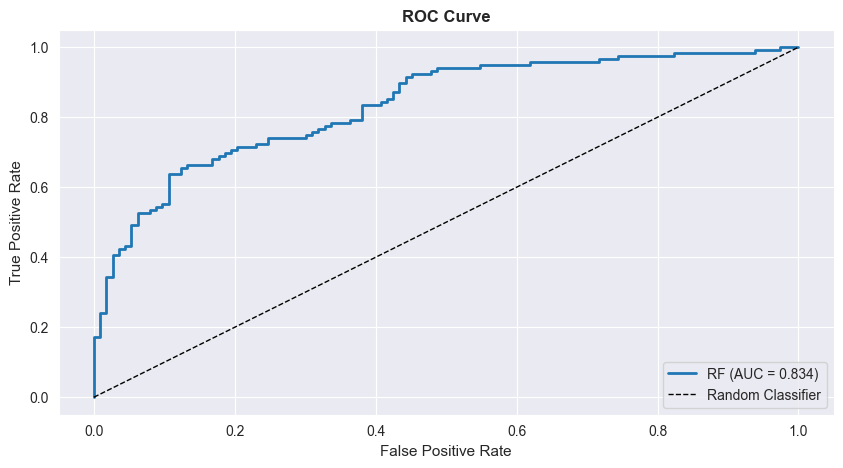

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_tuned)
ax.plot(fpr, tpr, linewidth=2, label=f'RF (AUC = {tuned_roc_auc:.3f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate', fontsize=11)
ax.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax.legend(loc='lower right')

plt.show()

The ROC curve demonstrates the models ability to discriminate between classes across all possible decision thresholds.

In [23]:
rocdf = pd.DataFrame({
    'FPR':fpr,
    'TPR':tpr,
})

rocdf.to_csv('roc_rf.csv', index=False)

## Feature Importance
### Gini Importance

Now that we have a trained Random Forest model, we can now try and see what features are actually driving the predictions. The first method we'll look at is Gini importance.

Recall from our theoretical section that at each node, the tree chooses a split that maximizes the reduction in Gini impurity. Gini importance leverages this by tracking how much each feature reduces impurity across all splits in all trees. Features that consistently produce large reductions in impurity are deemed the more important features.

However, we need to be careful when interpreting Gini importance. Gini importance is known to have biases like favoring features with high cardinality (many unique values) and features that appear near the root of trees. Because of this, we'll compare Gini importance against permutation importance and SHAP values.

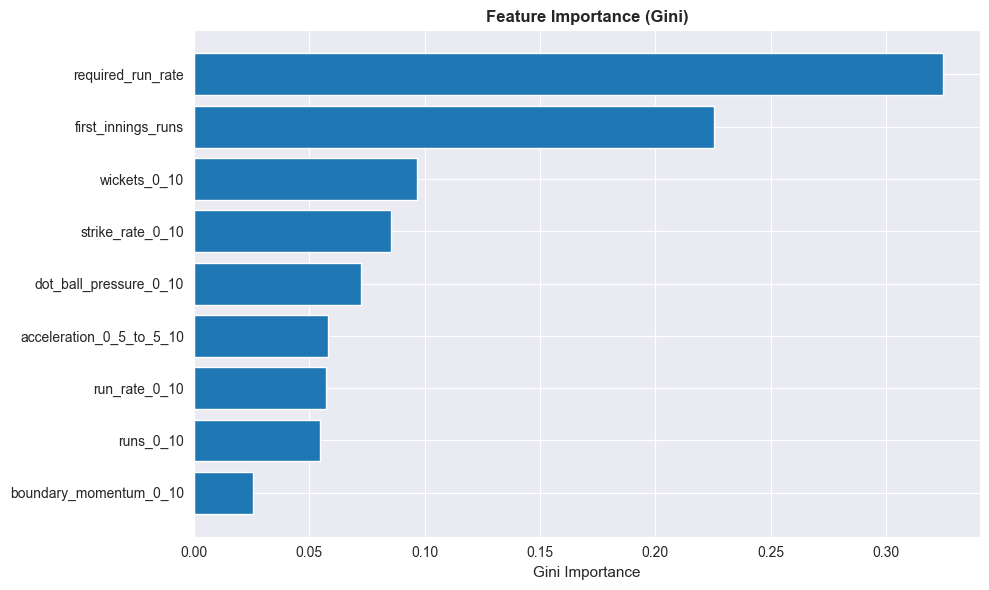


Feature Importance (Gini):
                 feature  importance
       required_run_rate    0.324429
      first_innings_runs    0.225443
            wickets_0_10    0.096579
        strike_rate_0_10    0.085569
  dot_ball_pressure_0_10    0.072553
acceleration_0_5_to_5_10    0.058066
           run_rate_0_10    0.057186
               runs_0_10    0.054704
  boundary_momentum_0_10    0.025472


In [15]:
feature_importance_gini = pd.DataFrame({'feature': feature_cols,'importance': rf_tuned.feature_importances_}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_gini['feature'], feature_importance_gini['importance'])
plt.xlabel('Gini Importance', fontsize=11)
plt.title('Feature Importance (Gini)', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nFeature Importance (Gini):")
print(feature_importance_gini.to_string(index=False))

The Gini importance rankings gives us an initial understanding of what features contribute the most to the tree splits. Features with a high Gini importance are frequently used for splitting and produce significant reductions in impurity.

### Permutation Importance

Permutation importance is another approach to measuring feature importance. Instead of looking at internal tree mechanics like Gini, it measures the impact each feature has on model performance.

For each feature, we randomly shuffle their values and then measure how much the models performance degrades. Features that cause a large drop in performance when shuffled are shown to be important for more accurate predictions. Features that cause small or no degradation when shuffled are shown to not contribute as much.

Permutation importance is model agnostic. The error bars in our visualization represent the variability across multiple permutation trials, giving us confidence intervals for each importance estimate.

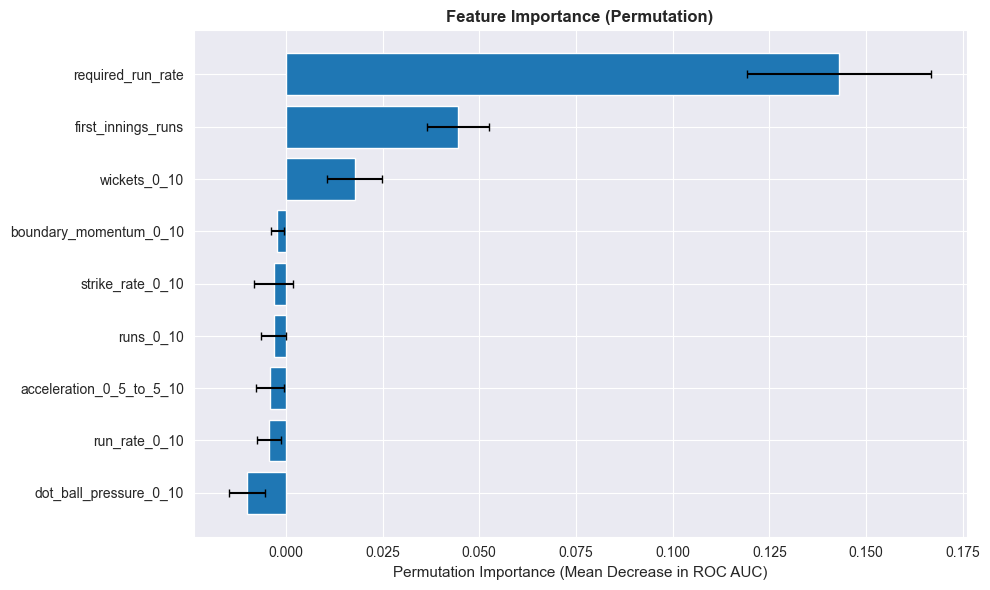


Permutation Feature Importance:
                 feature  importance      std
       required_run_rate    0.143111 0.023792
      first_innings_runs    0.044461 0.008015
            wickets_0_10    0.017775 0.007084
  boundary_momentum_0_10   -0.002182 0.001773
        strike_rate_0_10   -0.003174 0.004942
               runs_0_10   -0.003181 0.003235
acceleration_0_5_to_5_10   -0.004112 0.003595
           run_rate_0_10   -0.004310 0.003105
  dot_ball_pressure_0_10   -0.010085 0.004652


In [16]:
perm_importance = permutation_importance(rf_tuned,X_test,y_test,
    n_repeats=10, 
    random_state=RANDOM_STATE,
    scoring='roc_auc',
    n_jobs=-1
)

feature_importance_perm = pd.DataFrame({'feature': feature_cols,'importance': perm_importance.importances_mean,'std': perm_importance.importances_std}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_perm['feature'], feature_importance_perm['importance'])
plt.errorbar(feature_importance_perm['importance'], range(len(feature_importance_perm)),
    xerr=feature_importance_perm['std'],
    fmt='none',
    color='black',
    capsize=3
)
plt.xlabel('Permutation Importance (Mean Decrease in ROC AUC)', fontsize=11)
plt.title('Feature Importance (Permutation)', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nPermutation Feature Importance:")
print(feature_importance_perm.to_string(index=False))

Permutation importance tells us what features are needed for accurate predictions. Features with a high permutation importance cause significant performance degradation when shuffled, indicating their are critical. The error bars represent the variability across repeated permutations, with tighter bars indicating a more stable importance estimates.

### SHAP Values

While Gini and permutation importance tell us which features globally matter, they don't explain how features affect the individual predictions. This is where we can use SHAP values.

SHAP values are derived from shapely values in game theory. They can be interpreted as thinking of features as "players" in a "game" and how much credit each player should receive for the outcome.

For our application in cricket, this allows us to look at a specific match prediction and see exactly how much each feature pushed the prediction towards win or loss.

The TreeSHAP algorithm (Lundberg & Lee, 2017) makes this usable for Random Forests by exploiting the tree structure to compute exact Shapley values efficiently.

In [17]:
explainer = shap.TreeExplainer(rf_tuned)
shap_values = explainer.shap_values(X_test)

# We use shap_values[1] for the positive class (win)
if isinstance(shap_values, list):
    shap_values_class1 = shap_values[1]
else:
    shap_values_class1 = shap_values

print("SHAP values computed successfully.")

SHAP values computed successfully.


<Figure size 1000x800 with 0 Axes>

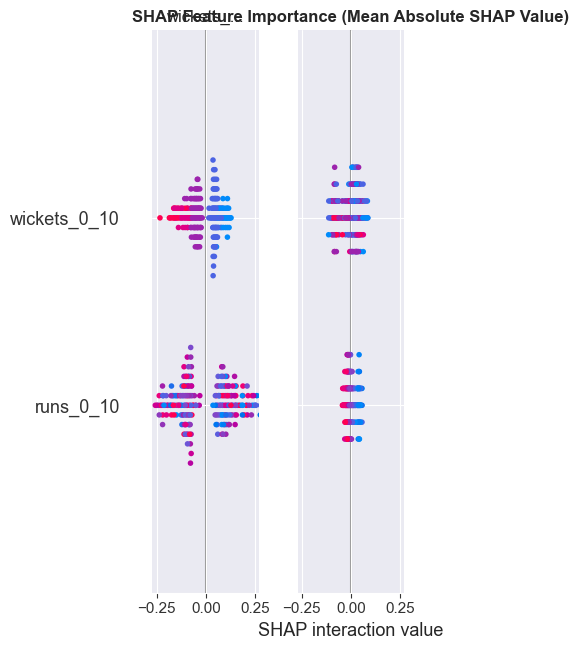

In [18]:
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_class1, X_test, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Mean Absolute SHAP Value)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

The SHAP bar plot shows the mean absolute SHAP value for each feature, representing the average magnitude of each feature's impact on the predictions. Features with larger mean absolute SHAP values have a greater overall influence on the models predictions.

<Figure size 1200x800 with 0 Axes>

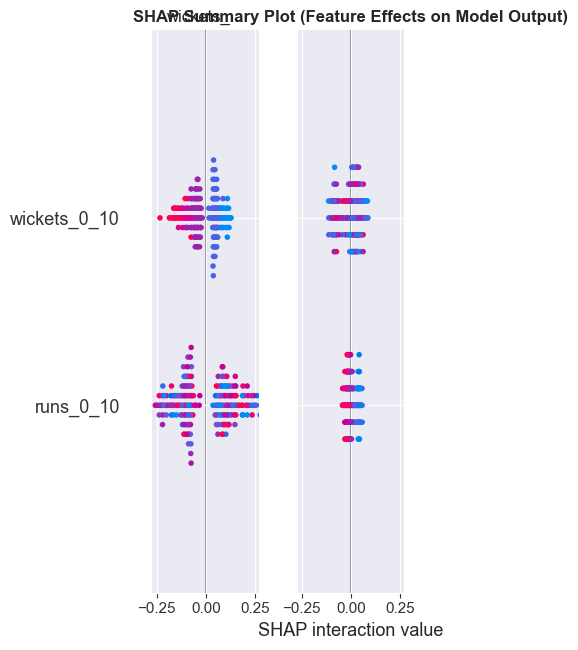

In [19]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_class1, X_test, show=False)
plt.title('SHAP Summary Plot (Feature Effects on Model Output)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

The SHAP summary plot provides more information by showing both the magnitude and direction of feature effects. Each point represents a single prediction, with the color indicating the feature value, and the x-axis showing the SHAP value. This visualization reveals non linear patterns, eg we can observe whether high values of a feature consistently push predictions toward wins or if the relationship is more complex than that.

## Conclusion

Our tuned Random Forest achieved a test ROC AUC of roughly 0.83, which is relatively good for something like cricket outcome prediction which is inherently unpredictable. Many factors in a cricket match play roles in the outcome that our features can't capture, so I am very happy this result. The reasons and assumptions listed at the beginning of the file imply that Random Forests are well suited for this context, and the results prove it.

Practically though, there are many limitations of this model. One is that for the obvious practical use (betting), the training time might take too long and hence not be effective. We also have that random forests cannot extrapolate means unprecedented results will result in inaccurate predictions. Additionally, The focus of this project was to get an understanding of Random Forests rather than maximising the ROC, which meant keeping features relatively simple, something that I would spend more time on if I were to carry on with this model eg accounting for changing match conditions like weather etc... Another thing I would change is that instead of providing point estimates, I would give interval estimates, as well as maybe extending this to other forms of cricket matches like T20 or test cricket. These limitations don't invalidate our results, but tell us where we can improve.

## References

- [1] Breiman, L. (2001). "Random Forests". *Machine Learning*, 45(1), 5-32.
- [2] Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The Elements of Statistical Learning: Data Mining, Inference, and Prediction* (2nd ed.). Springer. Chapter 15.
- [3] Louppe, G. (2014). "Understanding Random Forests: From Theory to Practice". PhD Thesis, University of Liège.
- [4] Breiman, L. (1996). "Bagging Predictors". *Machine Learning*, 24(2), 123-140.
- [5] Lundberg, S. M., & Lee, S. I. (2017). "A unified approach to interpreting model predictions". *Advances in Neural Information Processing Systems*, 30.
- [6] Friedman, J. H. (2001). "Greedy function approximation: A gradient boosting machine". *Annals of Statistics*, 29(5), 1189-1232.
- [7] Scikit-learn documentation on Random Forests: https://scikit-learn.org/stable/modules/ensemble.html#forest
- [8] Molnar, C. (2019). *Interpretable Machine Learning: A Guide for Making Black Box Models Explainable*. Available online: https://christophm.github.io/interpretable-ml-book/